# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 1000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 1,#2000, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 1000,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 500,
        'max_optimization_minutes': 120,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': 6,
        'use_gpu': True,
        'gpu_numbers': '3',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 


import warnings

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.4.1'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 56
[[3, 0, 0, 0, 0], [2, 1, 0, 0, 0], [2, 0, 1, 0, 0], [2, 0, 0, 1, 0], [2, 0, 0, 0, 1], [2, 0, 0, 0, 0], [1, 2, 0, 0, 0], [1, 1, 1, 0, 0], [1, 1, 0, 1, 0], [1, 1, 0, 0, 1], [1, 1, 0, 0, 0], [1, 0, 2, 0, 0], [1, 0, 1, 1, 0], [1, 0, 1, 0, 1], [1, 0, 1, 0, 0], [1, 0, 0, 2, 0], [1, 0, 0, 1, 1], [1, 0, 0, 1, 0], [1, 0, 0, 0, 2], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 3, 0, 0, 0], [0, 2, 1, 0, 0], [0, 2, 0, 1, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 0], [0, 1, 2, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 0], [0, 1, 0, 2, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 0], [0, 1, 0, 0, 2], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 2, 1, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 0], [0, 0, 1, 2, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 0], [0, 0, 1, 0, 2], [0, 0, 1, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 0], [0, 0, 0, 1, 2], [0, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0, 3], [0, 0, 0, 0, 2], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]


In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  285


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_285_drop0.25e1b256_custom/lnets_1000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_1000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  7.3min finished
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   10.8s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
521,1373158606,0

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
count,1000.000,1

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.68146172, 0.1184905 , 0.02265202, 0.02310833, 0.76552892],
       [0.63127172, 0.92960622, 0.777082  , 0.94614325, 0.49272907],
       [0.99700678, 0.05842097, 0.33548225, 0.47958363, 0.78862876],
       [0.78079292, 0.6764422 , 0.01483816, 0.2475837 , 0.51099547],
       [0.35669589, 0.00137119, 0.53863353, 0.25080249, 0.63459386],
       [0.55661215, 0.72748031, 0.49579823, 0.21593022, 0.87193343],
       [0.530412  , 0.09228566, 0.58538057, 0.10575269, 0.87039354],
       [0.29456917, 0.65861891, 0.06175531, 0.89077032, 0.90954028],
       [0.88441869, 0.98272036, 0.95327503, 0.94631285, 0.43063571],
       [0.04956725, 0.88087016, 0.89428038, 0.92049157, 0.56052759]])

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[ 0.17901041],
       [-0.42967844],
       [ 0.50559998],
       [-0.18638679],
       [-0.15561427],
       [-0.44704217],
       [-0.13966854],
       [-0.08392897],
       [-0.54715383],
       [-0.74754965]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(45000, 345)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(5000, 345)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 345)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
15722,1373158606

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
35587,1373158606

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,30000-target,21000-target,20100-target,20010-target,20001-target,20000-target,12000-target,11100-target,11010-target,11001-target,11000-target,10200-target,10110-target,10101-target,10100-target,10020-target,10011-target,10010-target,10002-target,10001-target,10000-target,03000-target,02100-target,02010-target,02001-target,02000-target,01200-target,01110-target,01101-target,01100-target,01020-target,01011-target,01010-target,01002-target,01001-target,01000-target,00300-target,00210-target,00201-target,00200-target,00120-target,00111-target,00110-target,00102-target,00101-target,00100-target,00030-target,00021-target,00020-target,00012-target,00011-target,00010-target,00003-target,00002-target,00001-target,00000-target,30000-lstsq_lambda,21000-lstsq_lambda,20100-lstsq_lambda,20010-lstsq_lambda,20001-lstsq_lambda,20000-lstsq_lambda,12000-lstsq_lambda,11100-lstsq_lambda,11010-lstsq_lambda,11001-lstsq_lambda,11000-lstsq_lambda,10200-lstsq_lambda,10110-lstsq_lambda,10101-lstsq_lambda,10100-lstsq_lambda,10020-lstsq_lambda,10011-lstsq_lambda,10010-lstsq_lambda,10002-lstsq_lambda,10001-lstsq_lambda,10000-lstsq_lambda,03000-lstsq_lambda,02100-lstsq_lambda,02010-lstsq_lambda,02001-lstsq_lambda,02000-lstsq_lambda,01200-lstsq_lambda,01110-lstsq_lambda,01101-lstsq_lambda,01100-lstsq_lambda,01020-lstsq_lambda,01011-lstsq_lambda,01010-lstsq_lambda,01002-lstsq_lambda,01001-lstsq_lambda,01000-lstsq_lambda,00300-lstsq_lambda,00210-lstsq_lambda,00201-lstsq_lambda,00200-lstsq_lambda,00120-lstsq_lambda,00111-lstsq_lambda,00110-lstsq_lambda,00102-lstsq_lambda,00101-lstsq_lambda,00100-lstsq_lambda,00030-lstsq_lambda,00021-lstsq_lambda,00020-lstsq_lambda,00012-lstsq_lambda,00011-lstsq_lambda,00010-lstsq_lambda,00003-lstsq_lambda,00002-lstsq_lambda,00001-lstsq_lambda,00000-lstsq_lambda,30000-lstsq_target,21000-lstsq_target,20100-lstsq_target,20010-lstsq_target,20001-lstsq_target,20000-lstsq_target,12000-lstsq_target,11100-lstsq_target,11010-lstsq_target,11001-lstsq_target,11000-lstsq_target,10200-lstsq_target,10110-lstsq_target,10101-lstsq_target,10100-lstsq_target,10020-lstsq_target,10011-lstsq_target,10010-lstsq_target,10002-lstsq_target,10001-lstsq_target,10000-lstsq_target,03000-lstsq_target,02100-lstsq_target,02010-lstsq_target,02001-lstsq_target,02000-lstsq_target,01200-lstsq_target,01110-lstsq_target,01101-lstsq_target,01100-lstsq_target,01020-lstsq_target,01011-lstsq_target,01010-lstsq_target,01002-lstsq_target,01001-lstsq_target,01000-lstsq_target,00300-lstsq_target,00210-lstsq_target,00201-lstsq_target,00200-lstsq_target,00120-lstsq_target,00111-lstsq_target,00110-lstsq_target,00102-lstsq_target,00101-lstsq_target,00100-lstsq_target,00030-lstsq_target,00021-lstsq_target,00020-lstsq_target,00012-lstsq_target,00011-lstsq_target,00010-lstsq_target,00003-lstsq_target,00002-lstsq_target,00001-lstsq_target,00000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165,wb_166,wb_167,wb_168,wb_169,wb_170,wb_171,wb_172,wb_173,wb_174,wb_175
666,1373158606,0

## Interpretation Network Training

In [23]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
176/176 [==============================] - 104s 537ms/step - loss: 0.2676 - r2_inet_lambda_fv_loss: 1.1399 - val_loss: 0.2135 - val_r2_inet_lambda_fv_loss: 0.2295
Training Time: 0:01:48
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:01


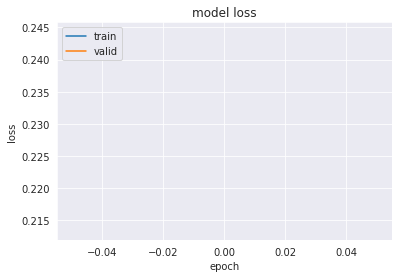

In [24]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [25]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [26]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [27]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [28]:
%load_ext autoreload

In [29]:
%autoreload 2
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [ ]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=6)]: Using backend SequentialBackend with 1 concurrent workers.


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43          50731.2        7        0.0968934        0.0846126      0.00s
best_fitness_generation 0.09689335421924879
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     7.30          1.45269        5        0.0939509        0.0887167      0.00s
best_fitness_generation 0.09395094509666536
best_fitness 0.09689335421924879
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length   

[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43          10687.9        7         0.119046         0.113588      0.00s
best_fitness_generation 0.1190457087606457
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     5.97          2.16675       17        0.0981647        0.0846055      0.00s
best_fitness_generation 0.0981646626224138
best_fitness 0.1190457087606457
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length      

[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43          11264.6        3         0.130705          0.12816      0.00s
best_fitness_generation 0.13070478608314473
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     7.22          12.8913        3         0.107289         0.105453      0.00s
best_fitness_generation 0.10728921228871711
best_fitness 0.13070478608314473
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length   

[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:  4.8min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43            10688        3         0.149269          0.17734      0.00s
best_fitness_generation 0.14926890176669985
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     7.15          1.89916        5        0.0723361        0.0749466      0.00s
best_fitness_generation 0.07233605952951333
best_fitness 0.14926890176669985
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length   

[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:  6.4min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43          11264.5        9         0.107362          0.14789      0.00s
best_fitness_generation 0.10736181031510325
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     5.94          13.1861        9          0.11069         0.117939      0.00s
best_fitness_generation 0.1106896862744307
best_fitness 0.10736181031510325
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length    

[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  8.5min remaining:    0.0s


   0    29.43          11715.9        7         0.132526         0.121099      0.00s
best_fitness_generation 0.13252565218965093
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     6.98          1.08761        5         0.122013         0.150735      0.00s
best_fitness_generation 0.12201274793970865
best_fitness 0.13252565218965093
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   2     4.29           0.9344        5        0.0755355        0.0935691      0.00s
best_fitness_generation 0.07553552583052818
best_fitness 0.12201274793970865
    |   Population Average    |         

[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 10.3min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43          5030.33        5        0.0608947        0.0585062      0.00s
best_fitness_generation 0.06089469994447205
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     6.47          4.94681        5        0.0590836        0.0748057      0.00s
best_fitness_generation 0.05908364179201924
best_fitness 0.06089469994447205
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length   

[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed: 12.7min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43          4918.15        7        0.0814211         0.091156      0.00s
best_fitness_generation 0.08142106142111134
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     6.44          1.44041       13        0.0663146        0.0588107      0.00s
best_fitness_generation 0.06631458073038658
best_fitness 0.08142106142111134
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length   

[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed: 14.0min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43           498858       11        0.0658272        0.0728694      0.00s
best_fitness_generation 0.06582715192692523
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     7.51          12.9412       11        0.0654398         0.076356      0.00s
best_fitness_generation 0.0654397535159505
best_fitness 0.06582715192692523
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length    

[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed: 15.4min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43          10687.9       15         0.176682         0.176841      0.00s
best_fitness_generation 0.17668186981660616
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     6.23          1.79566        5         0.146851         0.148376      0.00s
best_fitness_generation 0.14685089155562794
best_fitness 0.17668186981660616
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length   

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed: 17.7min remaining:    0.0s


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.43           325099        7        0.0840931        0.0799277      0.00s
best_fitness_generation 0.08409309723831852
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     7.31          26.2991       15        0.0610628        0.0707201      0.00s
best_fitness_generation 0.06106276523886788
best_fitness 0.08409309723831852
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length   

In [ ]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
%autoreload 2
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


In [ ]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [ ]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [ ]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [ ]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [ ]:
scores_test_list[-1]

In [ ]:
distrib_dict_test_list[-1]['MAE']

In [ ]:
distrib_dict_test_list[-1]['R2']

In [ ]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

In [ ]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



In [ ]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


In [ ]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


In [ ]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [ ]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [ ]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [ ]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()